In [1]:
def load_dataset(dataset_dir, grayscale=True):
    """
    Load images and labels from a dataset directory.
    Args:
        dataset_dir (str): Path to the dataset directory (e.g., Amazon, Caltech-10).
        grayscale (bool): Whether to load images in grayscale.
    Returns:
        Tuple of images and labels, along with the label map.
    """
    from collections import defaultdict
    images = []
    labels = []
    label_map = {}
    
    # Map categories to indices
    category_counter = 0
    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            if category not in label_map:
                label_map[category] = category_counter
                category_counter += 1

            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
                if image is not None:
                    images.append(image)
                    labels.append(label_map[category])

    print(f"Loaded {len(images)} images from {dataset_dir}.")
    return images, labels, label_map


In [5]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

base_dir = "../OfficeCaltechDomainAdaptation/images"
amazon_dir = os.path.join(base_dir, "amazon")
caltech_dir = os.path.join(base_dir, "caltech10")
dslr_dir = os.path.join(base_dir, "dslr")
webcam_dir = os.path.join(base_dir, "webcam")

# Load Amazon and Caltech-10 datasets
amazon_images, amazon_labels, amazon_label_map = load_dataset(amazon_dir)
caltech_images, caltech_labels, caltech_label_map = load_dataset(caltech_dir)

# Merge datasets
combined_images = amazon_images + caltech_images
combined_labels = amazon_labels + caltech_labels

# Stratified split for training and validation
X_train, X_val, y_train, y_val = train_test_split(
    combined_images, combined_labels, test_size=0.3, random_state=42, stratify=combined_labels
)

# Load DSLR dataset for testing
dslr_images, dslr_labels, dslr_label_map = load_dataset(dslr_dir)

# Load Webcam dataset for testing
webcam_images, webcam_labels, webcam_label_map = load_dataset(webcam_dir)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}")


Loaded 958 images from ../OfficeCaltechDomainAdaptation/images\amazon.
Loaded 1123 images from ../OfficeCaltechDomainAdaptation/images\caltech10.
Loaded 157 images from ../OfficeCaltechDomainAdaptation/images\dslr.
Loaded 295 images from ../OfficeCaltechDomainAdaptation/images\webcam.
Train: 1456, Validation: 625


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.manifold import TSNE

# Define dataset class
class CombinedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create PyTorch datasets and dataloaders
train_dataset = CombinedDataset(X_train, y_train, transform=transform)
val_dataset = CombinedDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load ResNet101 and modify for the number of categories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet101(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(amazon_label_map))  # Number of classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fine-tune the model
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")


# Extract features from the penultimate layer
penultimate_layer_model = nn.Sequential(*list(model.children())[:-1])  # Remove last layer
penultimate_features = []
labels_list = []

# Put the model in evaluation mode
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        features = penultimate_layer_model(images)
        features = features.view(features.size(0), -1)  # Flatten
        penultimate_features.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convert to numpy arrays
penultimate_features = np.concatenate(penultimate_features, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

label_map = amazon_label_map  # Make sure label_map is correctly assigned

# Plot t-SNE results, coloring points by category
plt.figure(figsize=(10, 8))
for category_id in np.unique(labels_list):
    idxs = np.where(labels_list == category_id)
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], 
                label=list(label_map.keys())[category_id], alpha=0.7, s=30)

plt.legend()
plt.title("t-SNE Visualization of Penultimate Layer Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


Epoch 1/50: 100%|██████████| 91/91 [00:04<00:00, 19.24it/s]


Epoch [1/50], Train Loss: 1.6715, Val Loss: 1.4711, Val Accuracy: 0.5312


Epoch 2/50: 100%|██████████| 91/91 [00:04<00:00, 21.10it/s]


Epoch [2/50], Train Loss: 1.1212, Val Loss: 1.3856, Val Accuracy: 0.5520


Epoch 3/50: 100%|██████████| 91/91 [00:04<00:00, 20.75it/s]


Epoch [3/50], Train Loss: 0.8661, Val Loss: 1.4124, Val Accuracy: 0.6176


Epoch 4/50: 100%|██████████| 91/91 [00:04<00:00, 20.55it/s]


Epoch [4/50], Train Loss: 0.7402, Val Loss: 1.3650, Val Accuracy: 0.6144


Epoch 5/50: 100%|██████████| 91/91 [00:04<00:00, 20.00it/s]


Epoch [5/50], Train Loss: 0.4889, Val Loss: 1.0065, Val Accuracy: 0.7376


Epoch 6/50: 100%|██████████| 91/91 [00:04<00:00, 20.11it/s]


Epoch [6/50], Train Loss: 0.4432, Val Loss: 0.9485, Val Accuracy: 0.7824


Epoch 7/50: 100%|██████████| 91/91 [00:04<00:00, 19.56it/s]


Epoch [7/50], Train Loss: 0.3520, Val Loss: 0.8850, Val Accuracy: 0.7824


Epoch 8/50: 100%|██████████| 91/91 [00:04<00:00, 20.44it/s]


Epoch [8/50], Train Loss: 0.4049, Val Loss: 0.8938, Val Accuracy: 0.7632


Epoch 9/50: 100%|██████████| 91/91 [00:04<00:00, 20.35it/s]


Epoch [9/50], Train Loss: 0.2981, Val Loss: 0.6566, Val Accuracy: 0.8256


Epoch 10/50: 100%|██████████| 91/91 [00:04<00:00, 20.93it/s]


Epoch [10/50], Train Loss: 0.2384, Val Loss: 0.7183, Val Accuracy: 0.8016


Epoch 11/50: 100%|██████████| 91/91 [00:04<00:00, 19.77it/s]


Epoch [11/50], Train Loss: 0.2189, Val Loss: 1.0896, Val Accuracy: 0.7776


Epoch 12/50: 100%|██████████| 91/91 [00:04<00:00, 19.88it/s]


Epoch [12/50], Train Loss: 0.1671, Val Loss: 0.6316, Val Accuracy: 0.8256


Epoch 13/50: 100%|██████████| 91/91 [00:04<00:00, 20.85it/s]


Epoch [13/50], Train Loss: 0.1935, Val Loss: 1.2809, Val Accuracy: 0.7472


Epoch 14/50: 100%|██████████| 91/91 [00:04<00:00, 20.47it/s]


Epoch [14/50], Train Loss: 0.2101, Val Loss: 0.8108, Val Accuracy: 0.8112


Epoch 15/50: 100%|██████████| 91/91 [00:04<00:00, 20.22it/s]


Epoch [15/50], Train Loss: 0.1498, Val Loss: 0.6781, Val Accuracy: 0.8416


Epoch 16/50: 100%|██████████| 91/91 [00:04<00:00, 20.69it/s]


Epoch [16/50], Train Loss: 0.1110, Val Loss: 1.0203, Val Accuracy: 0.7600


Epoch 17/50: 100%|██████████| 91/91 [00:04<00:00, 20.46it/s]


Epoch [17/50], Train Loss: 0.0880, Val Loss: 0.8743, Val Accuracy: 0.8320


Epoch 18/50: 100%|██████████| 91/91 [00:04<00:00, 20.46it/s]


Epoch [18/50], Train Loss: 0.1272, Val Loss: 0.7216, Val Accuracy: 0.8432


Epoch 19/50: 100%|██████████| 91/91 [00:04<00:00, 18.51it/s]


Epoch [19/50], Train Loss: 0.1195, Val Loss: 0.8998, Val Accuracy: 0.8112


Epoch 20/50: 100%|██████████| 91/91 [00:06<00:00, 13.48it/s]


Epoch [20/50], Train Loss: 0.1418, Val Loss: 0.7429, Val Accuracy: 0.8128


Epoch 21/50: 100%|██████████| 91/91 [00:06<00:00, 13.47it/s]


Epoch [21/50], Train Loss: 0.0965, Val Loss: 0.9353, Val Accuracy: 0.7952


Epoch 22/50: 100%|██████████| 91/91 [00:06<00:00, 13.52it/s]


Epoch [22/50], Train Loss: 0.1364, Val Loss: 0.9257, Val Accuracy: 0.7792


Epoch 23/50: 100%|██████████| 91/91 [00:06<00:00, 13.49it/s]


Epoch [23/50], Train Loss: 0.1367, Val Loss: 0.7657, Val Accuracy: 0.8352


Epoch 24/50: 100%|██████████| 91/91 [00:06<00:00, 13.46it/s]


Epoch [24/50], Train Loss: 0.0711, Val Loss: 0.9554, Val Accuracy: 0.8240


Epoch 25/50: 100%|██████████| 91/91 [00:06<00:00, 13.57it/s]


Epoch [25/50], Train Loss: 0.0591, Val Loss: 0.6558, Val Accuracy: 0.8528


Epoch 26/50: 100%|██████████| 91/91 [00:06<00:00, 13.65it/s]


Epoch [26/50], Train Loss: 0.0395, Val Loss: 0.7268, Val Accuracy: 0.8384


Epoch 27/50: 100%|██████████| 91/91 [00:06<00:00, 13.70it/s]


Epoch [27/50], Train Loss: 0.0307, Val Loss: 0.7641, Val Accuracy: 0.8480


Epoch 28/50: 100%|██████████| 91/91 [00:06<00:00, 13.69it/s]


Epoch [28/50], Train Loss: 0.0161, Val Loss: 0.6990, Val Accuracy: 0.8640


Epoch 29/50: 100%|██████████| 91/91 [00:06<00:00, 13.52it/s]


Epoch [29/50], Train Loss: 0.0089, Val Loss: 0.7677, Val Accuracy: 0.8432


Epoch 30/50: 100%|██████████| 91/91 [00:06<00:00, 13.34it/s]


Epoch [30/50], Train Loss: 0.0036, Val Loss: 0.6831, Val Accuracy: 0.8576


Epoch 31/50: 100%|██████████| 91/91 [00:06<00:00, 13.52it/s]


Epoch [31/50], Train Loss: 0.0031, Val Loss: 0.7192, Val Accuracy: 0.8464


Epoch 32/50: 100%|██████████| 91/91 [00:06<00:00, 13.65it/s]


Epoch [32/50], Train Loss: 0.0026, Val Loss: 0.7252, Val Accuracy: 0.8656


Epoch 33/50: 100%|██████████| 91/91 [00:06<00:00, 13.73it/s]


Epoch [33/50], Train Loss: 0.0024, Val Loss: 0.6516, Val Accuracy: 0.8672


Epoch 34/50: 100%|██████████| 91/91 [00:06<00:00, 13.58it/s]


Epoch [34/50], Train Loss: 0.0009, Val Loss: 0.6638, Val Accuracy: 0.8656


Epoch 35/50: 100%|██████████| 91/91 [00:06<00:00, 13.58it/s]


Epoch [35/50], Train Loss: 0.0084, Val Loss: 0.7846, Val Accuracy: 0.8288


Epoch 36/50: 100%|██████████| 91/91 [00:06<00:00, 13.49it/s]


Epoch [36/50], Train Loss: 0.1445, Val Loss: 4.4867, Val Accuracy: 0.4624


Epoch 37/50: 100%|██████████| 91/91 [00:06<00:00, 13.40it/s]


Epoch [37/50], Train Loss: 0.5711, Val Loss: 1.0000, Val Accuracy: 0.7664


Epoch 38/50: 100%|██████████| 91/91 [00:06<00:00, 13.48it/s]


Epoch [38/50], Train Loss: 0.1623, Val Loss: 0.8627, Val Accuracy: 0.7776


Epoch 39/50: 100%|██████████| 91/91 [00:06<00:00, 13.60it/s]


Epoch [39/50], Train Loss: 0.0622, Val Loss: 0.6544, Val Accuracy: 0.8304


Epoch 40/50: 100%|██████████| 91/91 [00:06<00:00, 13.52it/s]


Epoch [40/50], Train Loss: 0.0401, Val Loss: 0.6532, Val Accuracy: 0.8480


Epoch 41/50: 100%|██████████| 91/91 [00:06<00:00, 13.46it/s]


Epoch [41/50], Train Loss: 0.0130, Val Loss: 0.6213, Val Accuracy: 0.8640


Epoch 42/50: 100%|██████████| 91/91 [00:06<00:00, 13.33it/s]


Epoch [42/50], Train Loss: 0.0430, Val Loss: 0.9367, Val Accuracy: 0.8272


Epoch 43/50: 100%|██████████| 91/91 [00:06<00:00, 13.53it/s]


Epoch [43/50], Train Loss: 0.0406, Val Loss: 0.6680, Val Accuracy: 0.8608


Epoch 44/50: 100%|██████████| 91/91 [00:06<00:00, 13.66it/s]


Epoch [44/50], Train Loss: 0.0127, Val Loss: 0.7397, Val Accuracy: 0.8640


Epoch 45/50: 100%|██████████| 91/91 [00:06<00:00, 13.64it/s]


Epoch [45/50], Train Loss: 0.0137, Val Loss: 0.6664, Val Accuracy: 0.8768


Epoch 46/50: 100%|██████████| 91/91 [00:06<00:00, 13.58it/s]


Epoch [46/50], Train Loss: 0.0197, Val Loss: 0.7840, Val Accuracy: 0.8416


Epoch 47/50: 100%|██████████| 91/91 [00:06<00:00, 13.57it/s]


Epoch [47/50], Train Loss: 0.0483, Val Loss: 1.5902, Val Accuracy: 0.7712


Epoch 48/50: 100%|██████████| 91/91 [00:06<00:00, 13.56it/s]


Epoch [48/50], Train Loss: 0.2069, Val Loss: 1.5596, Val Accuracy: 0.7328


Epoch 49/50: 100%|██████████| 91/91 [00:06<00:00, 13.45it/s]


Epoch [49/50], Train Loss: 0.1049, Val Loss: 0.7461, Val Accuracy: 0.8240


Epoch 50/50: 100%|██████████| 91/91 [00:06<00:00, 13.43it/s]


Epoch [50/50], Train Loss: 0.0375, Val Loss: 0.7491, Val Accuracy: 0.8496


NameError: name 'label_map' is not defined

<Figure size 1000x800 with 0 Axes>

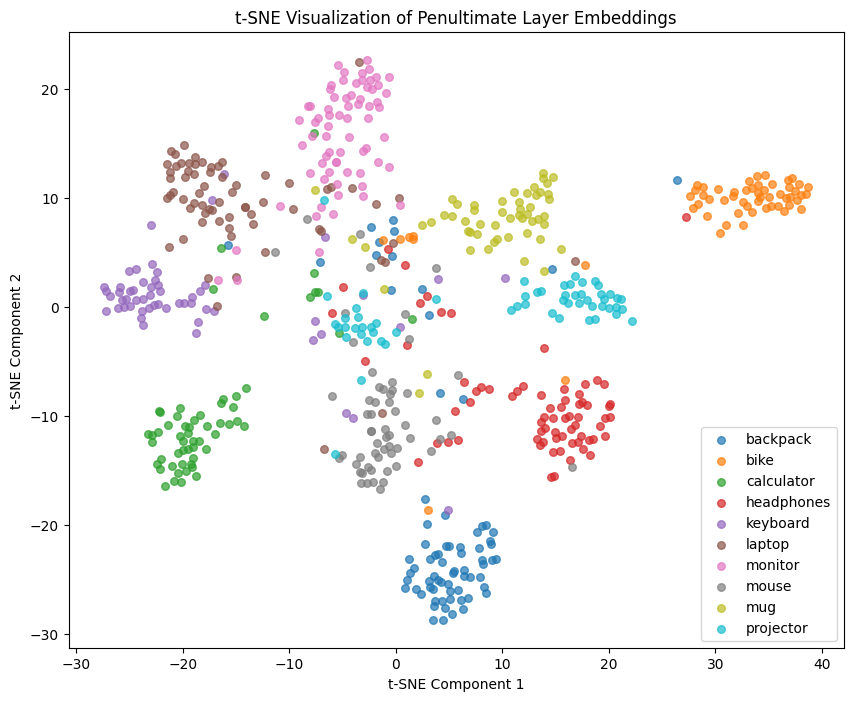

In [7]:
# Assuming amazon_label_map or similar is your label mapping
label_map = amazon_label_map  # Make sure label_map is correctly assigned

# Plot t-SNE results, coloring points by category
plt.figure(figsize=(10, 8))
for category_id in np.unique(labels_list):
    idxs = np.where(labels_list == category_id)
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], 
                label=list(label_map.keys())[category_id], alpha=0.7, s=30)

plt.legend()
plt.title("t-SNE Visualization of Penultimate Layer Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


Processing Dataset: 100%|██████████| 10/10 [00:00<00:00, 24.00it/s]


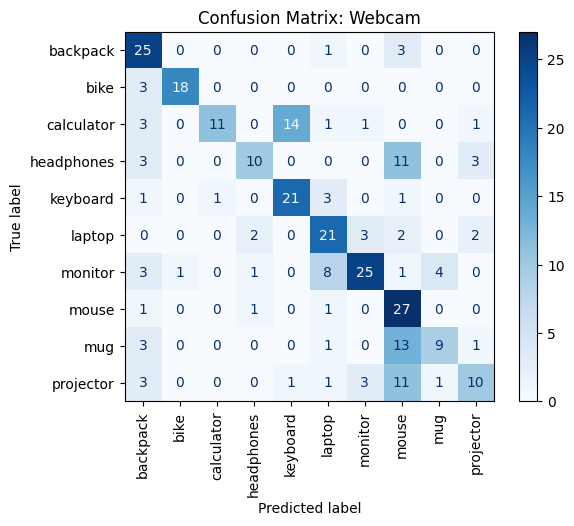

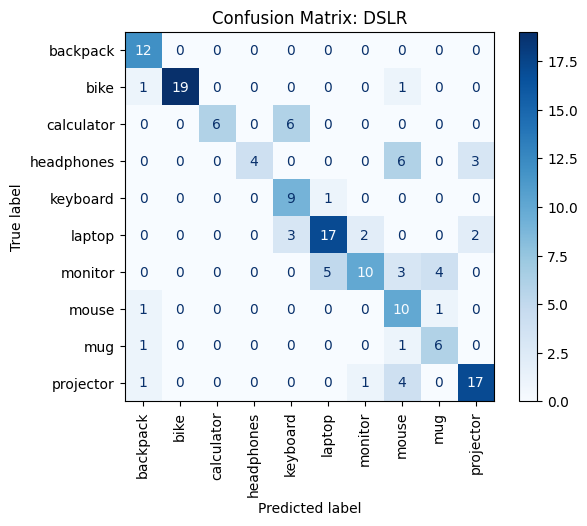

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define transformations (same as for training)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create PyTorch Dataset for Webcam and DSLR
class TestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Prepare datasets and dataloaders for Webcam and DSLR
webcam_dataset = TestDataset(webcam_images, webcam_labels, transform=test_transform)
dslr_dataset = TestDataset(dslr_images, dslr_labels, transform=test_transform)

webcam_loader = DataLoader(webcam_dataset, batch_size=16, shuffle=False)
dslr_loader = DataLoader(dslr_dataset, batch_size=16, shuffle=False)

# Extract features and predictions for both datasets
def extract_features_and_predict(loader, model, penultimate_layer_model):
    features = []
    labels = []
    predictions = []

    model.eval()
    with torch.no_grad():
        for images, true_labels in tqdm(loader, desc="Processing Dataset"):
            images = images.to(device)
            true_labels = true_labels.numpy()
            labels.extend(true_labels)

            # Extract features
            penultimate_features = penultimate_layer_model(images)
            penultimate_features = penultimate_features.view(penultimate_features.size(0), -1).cpu().numpy()
            features.extend(penultimate_features)

            # Get predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    return np.array(features), np.array(labels), np.array(predictions)

# Extract features and predictions for Webcam
webcam_features, webcam_true_labels, webcam_preds = extract_features_and_predict(
    webcam_loader, model, penultimate_layer_model
)

# Extract features and predictions for DSLR
dslr_features, dslr_true_labels, dslr_preds = extract_features_and_predict(
    dslr_loader, model, penultimate_layer_model
)

# Plot confusion matrix
def plot_confusion_matrix(true_labels, preds, label_map, dataset_name):
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title(f"Confusion Matrix: {dataset_name}")
    plt.show()

# Plot confusion matrix for Webcam
plot_confusion_matrix(webcam_true_labels, webcam_preds, amazon_label_map, "Webcam")

# Plot confusion matrix for DSLR
plot_confusion_matrix(dslr_true_labels, dslr_preds, amazon_label_map, "DSLR")


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Correct P and R combinations (Cartesian product)
from itertools import product

P_values = [8, 16, 24]  # Number of neighbors
R_values = [1, 2, 3]    # Radius
PR_combinations = list(product(P_values, R_values))  # All (P, R) combinations

# Extract multi-scale LBP features for combined dataset
def extract_multiscale_lbp_features(image, PR_combinations):
    """
    Extract multi-scale LBP features from an image.
    Args:
        image (np.array): Grayscale image
        PR_combinations (list of tuples): List of (P, R) combinations to use

    Returns:
        multiscale_features (np.array): Concatenated LBP histograms for all (P, R) combinations
    """
    multiscale_features = []
    for P, R in PR_combinations:
        lbp = local_binary_pattern(image, P, R, method="ror")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)
        multiscale_features.extend(lbp_hist)
    return np.array(multiscale_features)

X = []
y = []
for image, label in zip(combined_images, combined_labels):
    if image is not None:
        multiscale_lbp = extract_multiscale_lbp_features(image, PR_combinations)
        X.append(multiscale_lbp)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} LBP feature vectors")
print(f"Validation set: {len(X_val)} LBP feature vectors")
print(f"Feature vector length (multi-scale): {X_train.shape[1]}")

# Train an SVM classifier
svm = SVC(kernel="linear", random_state=42)  # Linear kernel
svm.fit(X_train, y_train)

# Predict on the validation set
y_pred = svm.predict(X_val)

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy with Multi-Scale LBP Features: {accuracy:.4f}")


Training set: 1664 LBP feature vectors
Validation set: 417 LBP feature vectors
Feature vector length (multi-scale): 162
Validation Accuracy with Multi-Scale LBP Features: 0.4125


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train SVM on scaled features
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_scaled = svm.predict(X_val_scaled)
accuracy_scaled = accuracy_score(y_val, y_pred_scaled)
print(f"Validation Accuracy with Scaled Features: {accuracy_scaled:.4f}")


Validation Accuracy with Scaled Features: 0.4556


In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define GLCM parameters
distances = [1, 2, 3]  # Multiple distances
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°

def compute_glcm_features(image, distances, angles):
    """
    Compute GLCM features for an image at multiple distances and angles.
    Args:
        image (np.array): Grayscale image
        distances (list): List of distances for GLCM calculation
        angles (list): List of angles (in radians) for GLCM calculation

    Returns:
        features (np.array): Concatenated GLCM features for all distances and angles
    """
    glcm_features = []
    for distance in distances:
        for angle in angles:
            glcm = graycomatrix(image, distances=[distance], angles=[angle], levels=256, symmetric=True, normed=True)
            glcm_features.extend([
                graycoprops(glcm, 'contrast')[0, 0],
                graycoprops(glcm, 'dissimilarity')[0, 0],
                graycoprops(glcm, 'homogeneity')[0, 0],
                graycoprops(glcm, 'correlation')[0, 0],
            ])
    return np.array(glcm_features)

# Extract GLCM features for the combined dataset
X = []
y = []

for image, label in zip(combined_images, combined_labels):
    if image is not None:
        features = compute_glcm_features(image, distances, angles)
        X.append(features)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} GLCM feature vectors")
print(f"Validation set: {len(X_val)} GLCM feature vectors")
print(f"Feature vector length: {X_train.shape[1]}")

# Train an SVM classifier
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_train, y_train)

# Validate the classifier
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy with GLCM Features: {accuracy:.4f}")


Training set: 1664 GLCM feature vectors
Validation set: 417 GLCM feature vectors
Feature vector length: 48
Validation Accuracy with GLCM Features: 0.4940


In [19]:
def compute_gabor_features(image, frequencies, angles):
    """
    Compute Gabor features for an image at multiple frequencies and angles.
    
    Args:
        image (np.array): Grayscale image
        frequencies (list): List of frequencies for Gabor filter
        angles (list): List of angles (in radians) for Gabor filter

    Returns:
        features (np.array): Concatenated Gabor features for all frequencies and angles
    """
    gabor_features = []
    for frequency in frequencies:
        for angle in angles:
            real, imag = gabor(image, frequency=frequency, theta=angle)
            magnitude = np.sqrt(real**2 + imag**2)
            
            # Compute statistical features for the magnitude response
            gabor_features.extend([
                np.mean(magnitude),  # Mean
                np.std(magnitude),   # Standard deviation
                np.median(magnitude),  # Median
                np.sum(magnitude)    # Sum (Energy)
            ])
    return np.array(gabor_features)

# Define Gabor parameters
frequencies = [0.05, 0.1, 0.2, 0.3, 0.5]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Extract Gabor features for the combined dataset
X = []
y = []

for image, label in zip(combined_images, combined_labels):
    if image is not None:
        features = compute_gabor_features(image, frequencies, angles)
        X.append(features)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} Gabor feature vectors")
print(f"Validation set: {len(X_val)} Gabor feature vectors")
print(f"Feature vector length: {X_train.shape[1]}")

# Train an SVM classifier
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_train, y_train)

# Validate the classifier
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy with Gabor Features: {accuracy:.4f}")

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for label in np.unique(y):
    idxs = np.where(y == label)
    plt.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], label=f"Label {label}", alpha=0.7, s=30)

plt.title("t-SNE Visualization of Gabor Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="upper right")
plt.show()


c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Training set: 1664 Gabor feature vectors
Validation set: 417 Gabor feature vectors
Feature vector length: 80


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [25]:
def compute_gabor_features(image, frequencies, angles):
    gabor_features = []
    epsilon = 1e-8  # Small value to prevent division or log issues
    for frequency in frequencies:
        for angle in angles:
            real, imag = gabor(image, frequency=frequency, theta=angle)
            magnitude = np.sqrt(real**2 + imag**2) + epsilon  # Add epsilon to avoid zero magnitude
            gabor_features.extend([
                np.mean(magnitude),
                np.std(magnitude),
                np.median(magnitude),
                np.sum(magnitude)
            ])
    return np.array(gabor_features)


In [26]:
from sklearn.preprocessing import StandardScaler

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)


Validation Accuracy with Gabor Features: 0.5468


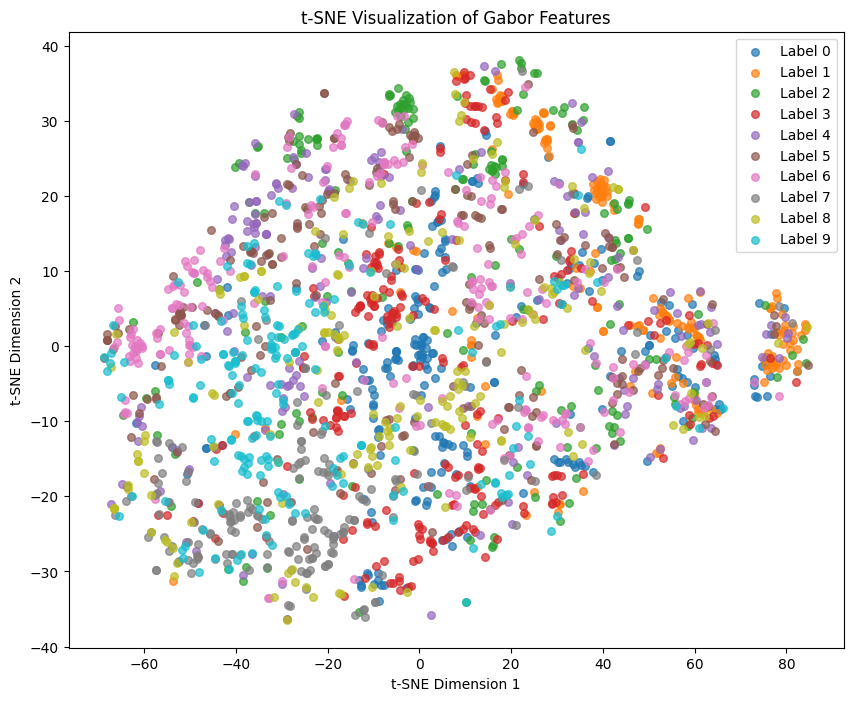

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

X = []  # Initialize as a Python list for collecting features
y = []  # Initialize as a Python list for collecting labels

for image, label in zip(combined_images, combined_labels):
    if image is not None:
        features = compute_gabor_features(image, frequencies, angles)
        X.append(features)  # Append features to the list
        y.append(label)     # Append corresponding label to the list

# Convert lists to NumPy arrays after collection
X = np.array(X)
y = np.array(y)

# Check for invalid values
if not np.all(np.isfinite(X)):
    print("Warning: Feature matrix contains invalid values. Replacing...")
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Proceed with training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train an SVM classifier
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_train, y_train)

# Validate the classifier
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy with Gabor Features: {accuracy:.4f}")

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for label in np.unique(y):
    idxs = np.where(y == label)
    plt.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], label=f"Label {label}", alpha=0.7, s=30)

plt.title("t-SNE Visualization of Gabor Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="upper right")
plt.show()
